## 'Biomechanical features of orthopedic patients' - Workbook

### By Henry Bazakas

via: https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients?select=column_3C_weka.csv

This notebook aims to predict the orthopedic diagnosis of patients based on their biomechanical features. It does so by utilizing a variety of machine learning approaches. For information on these different approaches and the implementations used here I recommend consulting <a href = 'https://scikit-learn.org/stable/index.html'> scikit-learn.org </a>.

In all, I was able to predict with 87.1% accuracy whether orthopedic patient's diagnosis was normal, hernia, or spondylolisthesis. This accuracy was attained using a logistic regression model. Marginally lower accuracies were attained using random forests, k-nearest neighbors, stochastic descent, and naive bayes classifiers. I also used several implementations of ensemble classification, although it did not increase the accuracy on my test dataset.

The results of this analysis are promising, and continued work on this problem could be used for more rapid diagnosis of spinal conditions. Keep in mind the limitations of these results, as well as the opportunities presented by training these types of models on larger datasets.

----

I began this analysis with a Kaggle dataset of 310 orthopedic patients. It includes 6 measurements about them as well as their clinical diagnosis.

The included features are as follows:

* <b>pelvic_incidence</b>, defined as "the angle between a line perpendicular to the sacral plate at its midpoint and a line connecting this point to the femoral head axis" <a href = "https://www.hindawi.com/journals/ari/2014/594650/">here</a>. Pelvic incidence is equal to pelvic tile plus sacral slope, and thus willl <b>not</b> be used for prediction.
* <b>pelvic_tilt</b>, defined as "a position-dependent parameter defined as the angle created by a line running from the sacral endplate midpoint to the center of the bifemoral heads and the vertical axis" <a href = "">here</a>.
* <b>lumbar_lordosis_angle</b>, defined <a href = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6050761/">here</a> as "the curvature assumed by intact lumbar spine to compensate for the inclination of the sacrum, restore an upward spinal orientation, and consequently avoid a forward inclination."
* <b>sacral_slope</b>, the angle between the horizontal and the sacral plate as defined <a href = "https://thejns.org/spine/view/journals/j-neurosurg-spine/23/6/article-p754.xml#:~:text=Sacral%20slope%20is%20defined%20as,greater%20the%20likelihood%20of%20spondylolisthesis.">here</a>.
* <b>pelvic_radius</b> is "measured from the PR line to the horizontal", as explained <a href = "https://journals.lww.com/spinejournalabstracts/fulltext/2009/10003/pelvic_radius_angle__an_essential_parameter_for.49.aspx">here</a>.
* <b>degree_spondylolisthesis</b>."Spondylolisthesis is a spinal condition that causes lower back pain. It occurs when one of your vertebrae, the bones of your spine, slips out of place onto the vertebra below it." <a href = "https://my.clevelandclinic.org/health/diseases/10302-spondylolisthesis">(link)</a>. This variable measures the degree to which the vertebrae have slipped.

These measures are used by othopedists to diagnose patients with different spinal conditions. For the purpose of this analysis I will attempt to use machine learning frameworks to use them as determinants of a patient's condition. The three options represented in this dataset are: Normal (100 patients), Disk Hernia (60 Patients), and Spondylolisthesis (150 patients).


The image below, via <a href = "https://www.researchgate.net/figure/Sagittal-pelvic-parameters-based-on-standing-radiograph-The-pelvic-incidence-PI-is_fig1_5251672">ResearchGate.net</a> illustrates some of these angles in a spinal diagram.
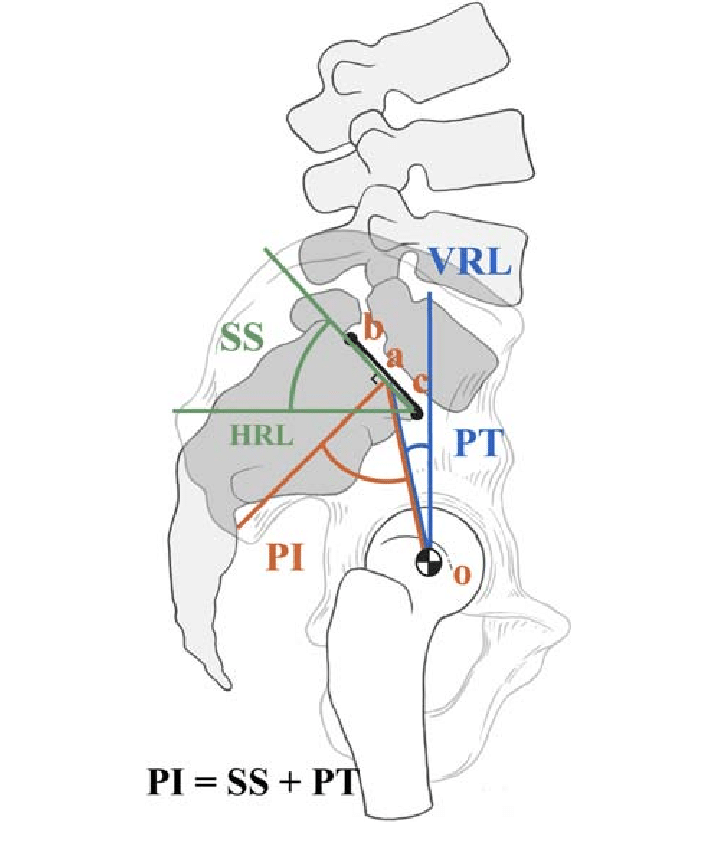

## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier

## EDA/Cleaning

In [ ]:
data = pd.read_csv('column_3C_weka.csv')

In [ ]:
data.columns

In [ ]:
data.head()

In [ ]:
data.describe()

The dataset contains the six variables described above as well as a variable 'class' which denotes the diagnosis provided to each patient.

It has 310 rows, each with no NA's. Ranges and percentiles for each numeric variable are shown above. Below, I confirm that the counts for each class are as stated above.

In [ ]:
data['class'].value_counts()

In [ ]:
#Recode diagnoses to binary. 1 = abnormal, 0 = normal.
#This leaves us with 210 abnormal cases and 100 normal ones.

data.loc[data['class']=='Normal', 'b_class'] = 0
data.loc[data['class']!='Normal', 'b_class'] = 1

In [ ]:
data

In [ ]:
#Split data into train and test sets, representing 80% and 20% of the data.
#These are used to train models and fairly assess their performance. 
#Data was scrambled to ensure random ditribution of diagnoses.

scrambled = data.sample(frac = 1, replace = False)
train = scrambled[0:248]
test = scrambled[248:310]

train_X = train[['pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
train_Y = train['class']
train_Y_b = train['b_class']

test_X = test[['pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
test_Y = test['class']
test_Y_b = test['b_class']


print(train.shape, test.shape)
print(train_X.shape, train_Y.shape, train_Y_b.shape)
print(test_X.shape, test_Y.shape, test_Y_b.shape)


In [ ]:
#Checking that classes are all represented in both train and test data.
print("Train:\n",
      train_Y.value_counts(),
      "\n\nTest\n",
      test_Y.value_counts())

In [ ]:
#Observe that the training day includes a range of classes and binary classes.
#X is the five numeric columns while Y is the class or binary class.
#This X and Y are what we will use to train and evaluate ML algorithms.
print(train_X.head(), train_Y.head())

## Modeling

### Logistic Regression

In [ ]:
max_acc = 0
opt_c = 0
for c in [0.001, 0.1, 0.1, 1, 2, 5, 7, 10, 1000, 10000]:
    log_reg = LogisticRegression(C = c, solver = 'newton-cg', multi_class = 'multinomial').fit(train_X, train_Y)
    acc = np.mean(log_reg.predict(test_X) == test_Y)
    if round(acc,4) > max_acc:
        max_acc = round(acc,4)
        opt_c = c
print(c, 100*max_acc)

In [ ]:
log_reg = LogisticRegression()
parameters = {
    'solver':['newton-cg', 'liblinear'],
    'multi_class':['auto'],
    'C':[0.01, 0.1, 1, 10, 100],
}
grid = GridSearchCV(log_reg, parameters, cv = 5)
grid.fit(train_X, train_Y)
print("Best Model:", grid.best_estimator_)

pred_Y = grid.predict(test_X)

print("Accuracy:", 100*round(np.mean(pred_Y==test_Y),4))

print("Confusion Matrix:\n", confusion_matrix(test_Y, pred_Y))

In [ ]:
grid_b = GridSearchCV(log_reg, parameters, cv = 5)
grid_b.fit(train_X, train_Y_b)
print("Best Model:", grid_b.best_estimator_)

pred_Y_b = grid_b.predict(test_X)

print("Accuracy:", round(100*np.mean(pred_Y_b==test_Y_b),2))

print("Confusion Matrix:\n", confusion_matrix(test_Y_b, pred_Y_b))

Using grid search to try various hyperparameters we achieve a maximum accuracy of 87.1%. Interestingly we achieve the same accuracy, albeit with different hyperparameters, on the binary version of the data. Both predict the correct class 54 times out of the 62 observations in the test set.

This means that logistic regression is able to predict with 87.1% accuracy whether a patient has a spinal abnormality, using only the 5 metrics above. It also does a fairly good job of predicting whether the abnormality is a hernia or spondylolisthesis - it correctly identified 12 of 14 cases of hernias and 27 of 29 cases of sponylolisthesis, with only one misclassification occurring between the two classes. The other misclassifications were 3 patients who were mistakenly thought to have no underlying condition and 4 who were mistakenly identified as having either a hernia or spondylolisthesis.

This accuracy, while high, can likely be improved upon. Next I will try different machine learning algorithms to see if they provide direct improvement on this result or can be used in an ensemble model to produce higher accuracy values.

### AdaBoost

In [ ]:
log_reg = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


ada = AdaBoostRegressor(base_estimator = log_reg, n_estimators=100)
ada.fit(train_X, train_Y_b)
ada_pred = ada.predict(test_X)
acc = np.mean(ada_pred == test_Y_b)


print("Accuracy:", round(100*acc,2))

Adaboost is an ensemble regressor. It operates by starting with a regression model and training it on its misidentified items in hopes that future iterations successfully correct them.

In this case, accuracy did not improve. Adaboost iteration of the previous logistic regression yielded an accuracy of 85.48%

### Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(train_X, train_Y_b)
tree_pred = tree.predict(test_X)
acc = np.mean(tree_pred == test_Y_b)

  
print("Accuracy:", round(100*acc,2))

Poor performance out of the box.

In [ ]:
parameters = {'criterion':['mse','friedman_mse','mae'],
              'splitter':['best','random'],
              'max_depth':[1,3,5,15,25,500],
              'min_samples_split':[2,3,4,5,10]
}


tree_grid = GridSearchCV(tree, parameters, cv = 5)
tree_grid.fit(train_X, train_Y_b)
print("Best Model:", tree_grid.best_estimator_)

tree_pred_best = grid_b.predict(test_X)
acc = np.mean(tree_pred_best == test_Y_b)
print("Accuracy:", round(100*acc,2))

print("Confusion Matrix:\n", confusion_matrix(test_Y_b, tree_pred_best))

After tuning with hyperparameters, the classifier performs as well as logistic regression. It is only predicting normal/abnormal rather than specific classes but it is still an interesting result. Next we will explore an extension of decision tree classifiers: random forests.

### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(train_X, train_Y)
rf_pred = rf.predict(test_X)
acc = np.mean(rf_pred == test_Y)

print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, rf_pred))

In [ ]:
parameters = {'n_estimators':[5,25,50,100,150],
              'max_depth':[1,5,10,25,100,150],
              'criterion':['gini','entropy'],
              'bootstrap':[True, False]
}


rf_grid = GridSearchCV(rf, parameters, cv = 5)
rf_grid.fit(train_X, train_Y)
print("Best Model:", rf_grid.best_estimator_)

rf_grid_best = rf_grid.predict(test_X)
acc = np.mean(rf_grid_best == test_Y)
print("Accuracy:", round(100*acc,2))

print("Confusion Matrix:\n", confusion_matrix(test_Y, rf_grid_best))

The random forest classifier performed decently well before hyperparameter tuning, achieving an accuracy of 79.03%. This improved slightly to 80.65% after adjusting various hyperparameters. While this is not at the level achieved by logistic regression it is a fairly accurate classifier.

### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(train_X, train_Y)
nb_pred = nb.predict(test_X)
acc = np.mean(nb_pred == test_Y)

print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, nb_pred))

In [ ]:
parameters = {
    'var_smoothing':[1e-9, 1e-5, 1e-3, 1, 100]
}

nb_grid = GridSearchCV(nb, parameters, cv = 5)
nb_grid.fit(train_X, train_Y)
print("Best Model:", nb_grid.best_estimator_)
nb_grid_pred = nb_grid.predict(test_X)
acc = np.mean(nb_grid_pred == test_Y)
print("Accuracy:", round(100*acc,2))

#Default value for variable_smoothing is optimal it turns out.
#Could adjust priors w more domain knowledge. 
#Didn't seem appropriate given limited and likely non-representative dataset.

Before any hyperparameter tuning, Naive Bayes performed respectably, achieving an accuracy of 82.26%. This was not improved by hyperparameter tuning.

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_X, train_Y)
knn_pred = knn.predict(test_X)
acc = np.mean(knn_pred == test_Y)

print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, knn_pred))

In [ ]:
parameters = {
    'n_neighbors':[1,5,9,11,15,17,19,21],
    'algorithm':['auto','ball_tree','kd_tree','brute'],
    'p':[1,2],
}

knn_grid = GridSearchCV(knn, parameters, cv = 5)
knn_grid.fit(train_X, train_Y)
print("Best Model:", knn_grid.best_estimator_)
knn_grid_pred = knn_grid.predict(test_X)
acc = np.mean(knn_grid_pred == test_Y)
print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, knn_grid_pred))

Here we were able to improve upon the default algorithm via grid searching through hyperparameters. Accuracy on test data increased from 77.42% to 80.65%.

### Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier()
sgd.fit(train_X, train_Y)
sgd_pred = sgd.predict(test_X)
acc = np.mean(sgd_pred == test_Y)
print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, sgd_pred))

Without adjusting hyperparameters, stochastic gradient descent does a very poor job of identifying hernias, leading to a low accuracy score. It is doing a good job of properly identifying normal and spondylolisthesis diagnoses, but is classifying most hernia as normal. Let's see if this improves after tuning.

In [ ]:
parameters = {
    'loss':['hinge','log','modified_huber','squared_hinge','squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty':['l1','l2','elasticnet'],
    'alpha':[0.0001, 0.01, 1, 10],
    'max_iter':[100000]
}

sgd_grid = GridSearchCV(sgd, parameters, cv = 5)
sgd_grid.fit(train_X, train_Y)
print("Best Model:", sgd_grid.best_estimator_)
sgd_grid_pred = sgd_grid.predict(test_X)
acc = np.mean(sgd_grid_pred == test_Y)
print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, sgd_grid_pred))

After using grid search to optimize hyperparameters, accuracy increased substantially into the 80%s. Note that this is not a deterministic process, so accuracy does vary based on interation.

### Ensemble Method using best Estimators above

Finally, we will attempt to assemble a better estimator than any listed above by combining them and voting. The code below uses the best estimators, as determined by Grid Search, for logistic regression, naive bayes, and k nearest neighbors. Then, it has all three predict the classes of the test data and predicts the most common prediction amongst the three estimators. Its results are below.

In [ ]:
#Here we combine the three best regressors to see if they can be improved working together.
#We will have all three predict a class, and then vote.

log_reg = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
nb = GaussianNB(priors=None, var_smoothing=1e-09)
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=150, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
sgd = SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

log_reg.fit(train_X, train_Y)
nb.fit(train_X, train_Y)
knn.fit(train_X, train_Y)
rf.fit(train_X, train_Y)
sgd.fit(train_X, train_Y)


log_reg_pred = log_reg.predict(test_X)
nb_pred = nb.predict(test_X)
knn_pred = knn.predict(test_X)
rf_pred = rf.predict(test_X)
sgd_pred = sgd.predict(test_X)

In [ ]:
#Manual implementation

ensemble_pred = []
for i in range(len(test_X)):
    votes = pd.Series([log_reg_pred[i], nb_pred[i], knn_pred[i], rf_pred[i], sgd_pred[i]])
    ensemble_pred.append(votes.value_counts().index[0])

acc = np.mean(ensemble_pred == test_Y)
print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, ensemble_pred))

In the end this ensemble method was unable to predict the classes better than the logistic regression alone, although it was an improvement on the other two estimators.

In [ ]:
#Sklearn implementation

vote = VotingClassifier(estimators=[('lr', log_reg), ('nb', nb), ('knn', knn), ('rf', rf), ('sgd', sgd)],
    voting='hard')
vote.fit(train_X, train_Y)
vote_pred = vote.predict(test_X)
acc = np.mean(vote_pred == test_Y)

print("Accuracy:", round(100*acc,2))
print("Confusion Matrix:\n", confusion_matrix(test_Y, vote_pred))

### Conclusion

For this classification problem it appears that logistic regression or stochastic gradient descent provide the most accurate results. The reason I include stochastic gradient descent in the conversation is that sometimes it outperforms logistic regression, depending on how the classifier trains (it is a non-deterministic process so results vary). Ensemble predictions also provide a high level of accuracy and may improve with larger datasets.

These results are encouraging but I believe they would improve greatly with more data. The 310 patients on which these classifiers were trained represent a relatively small number, and if I had a more robust dataset I believe I could achieve better accuracies. Nonetheless this is a positive result, and shows the promise of using machine learning in clinical diagnoses.